In [1]:
!pip install pyvi
!pip install pydot
!pip install pydot_ng
!pip install graphviz


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
from keras.utils.np_utils import to_categorical
%matplotlib inline

In [2]:
data_train = pd.read_csv("vlsp_sentiment_train.csv", sep='\t')
data_train.columns =['Class', 'Data']
data_test = pd.read_csv("vlsp_sentiment_test.csv", sep='\t')
data_test.columns =['Class', 'Data']

In [3]:
print(data_train.shape)
print(data_test.shape)

(5100, 2)
(1050, 2)


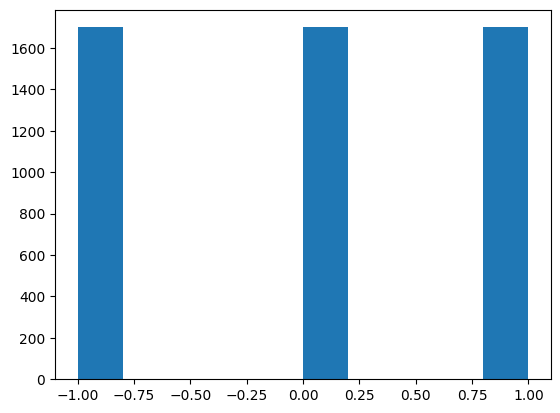

In [4]:
import matplotlib.pyplot as plt

plt.hist(data_train["Class"])
plt.show()

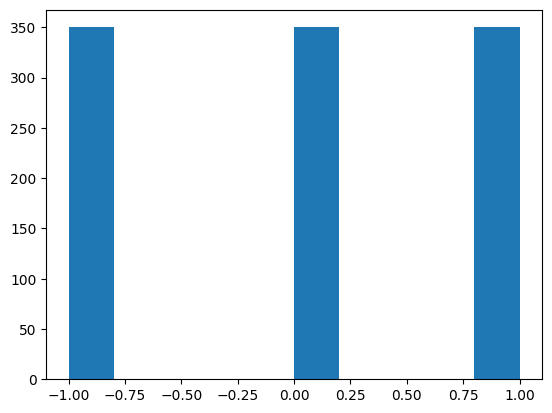

In [5]:
plt.hist(data_test["Class"])
plt.show()

In [6]:
labels = data_train.iloc[:, 0].values
reviews = data_train.iloc[:, 1].values

In [7]:
encoded_labels = []

for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label == 0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

encoded_labels = np.array(encoded_labels)  

In [8]:
reviews_processed = []
unlabeled_processed = [] 
for review in reviews:
    review_cool_one = ''.join([char for char in review if char not in digits])
    reviews_processed.append(review_cool_one)

In [9]:
#Use PyVi for Vietnamese word tokenizer
word_reviews = []
all_words = []
for review in reviews_processed:
    review = ViTokenizer.tokenize(review.lower())
    word_reviews.append(review.split())
   

In [10]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 300 # max number of words in a comment to use

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical

In [12]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index


In [13]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [14]:
print('Shape of X train and X validation tensor:',data.shape)
print('Shape of label train and validation tensor:', labels.shape)

Shape of X train and X validation tensor: (5100, 300)
Shape of label train and validation tensor: (5100, 3)


In [15]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('vi-model-CBOW.bin', binary=True)


vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [16]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Dropout,concatenate
from keras.layers import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
# reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
print(conv_1)
maxpool_0 = MaxPooling1D(sequence_length - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(sequence_length - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(sequence_length - filter_sizes[2] + 1, strides=1)(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)


# this creates a model that includes
model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]


KerasTensor(type_spec=TensorSpec(shape=(None, 297, 100), dtype=tf.float32, name=None), name='conv1d_1/Relu:0', description="created by layer 'conv1d_1'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 400)     3167600     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 298, 100)     120100      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 

c:\Users\Quynh Huong\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


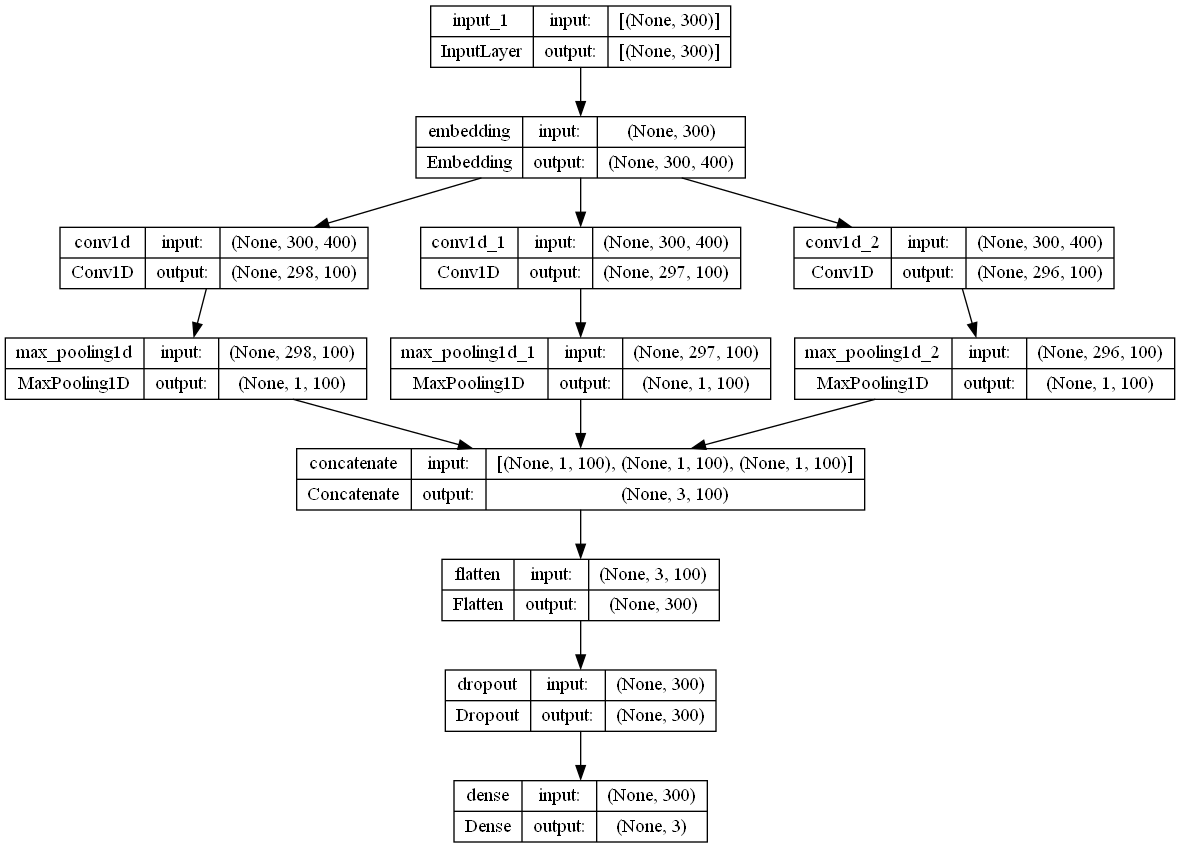

In [17]:
tf.keras.utils.plot_model(model, to_file="./visualize_CNN_model.png", show_shapes=True)

In [18]:
model_history = model.fit(data, labels, validation_split=0.2,
          epochs=32, batch_size=256, callbacks=callbacks_list, shuffle=True)

Epoch 1/32
16/16 [==============================] - 17s 1s/step - loss: 7.4024 - accuracy: 0.4515 - val_loss: 7.7539 - val_accuracy: 0.0402
Epoch 2/32
16/16 [==============================] - 17s 1s/step - loss: 5.4219 - accuracy: 0.6208 - val_loss: 6.7011 - val_accuracy: 0.0833
Epoch 3/32
16/16 [==============================] - 17s 1s/step - loss: 4.5098 - accuracy: 0.7199 - val_loss: 6.1746 - val_accuracy: 0.0794
Epoch 4/32
16/16 [==============================] - 19s 1s/step - loss: 3.8664 - accuracy: 0.7980 - val_loss: 5.7598 - val_accuracy: 0.0490
Epoch 5/32
16/16 [==============================] - 18s 1s/step - loss: 3.3514 - accuracy: 0.8441 - val_loss: 5.1453 - val_accuracy: 0.0804
Epoch 6/32
16/16 [==============================] - 19s 1s/step - loss: 2.9106 - accuracy: 0.8824 - val_loss: 4.4391 - val_accuracy: 0.1461
Epoch 7/32
16/16 [==============================] - 18s 1s/step - loss: 2.5481 - accuracy: 0.9015 - val_loss: 4.6065 - val_accuracy: 0.0696
Epoch 8/32
16/16 [==

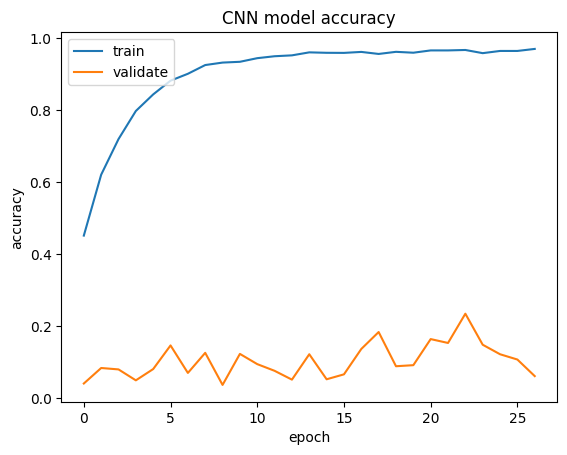

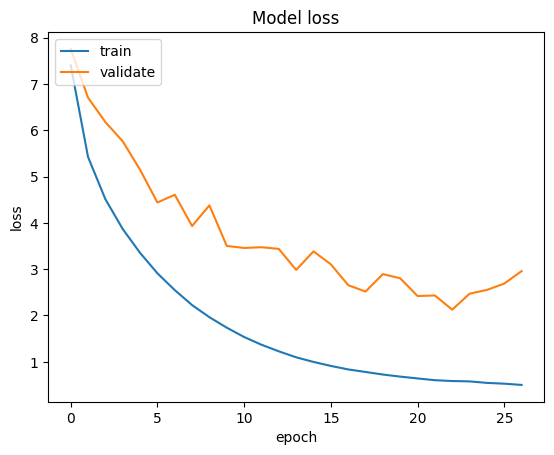

In [19]:
import matplotlib.pyplot as plt 

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [20]:
labels_test = data_test.iloc[:, 0].values
reviews_test = data_test.iloc[:, 1].values

In [21]:
encoded_labels_test = []

for label_test in labels_test:
    if label_test == -1:
        encoded_labels_test.append([1,0,0])
    elif label_test == 0:
        encoded_labels_test.append([0,1,0])
    else:
        encoded_labels_test.append([0,0,1])

encoded_labels_test = np.array(encoded_labels_test)  

In [22]:
reviews_processed_test = []
unlabeled_processed_test = [] 
for review_test in reviews_test:
    review_cool_one = ''.join([char for char in review_test if char not in digits])
    reviews_processed_test.append(review_cool_one)

In [23]:
#Use PyVi for Vietnamese word tokenizer
word_reviews_test = []
all_words = []
for review_test in reviews_processed_test:
    review_test = ViTokenizer.tokenize(review_test.lower())
    word_reviews_test.append(review_test.split())

In [24]:
sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

In [25]:
print('Shape of X test and X validation tensor:',data_test.shape)
print('Shape of label test and validation tensor:', labels_test.shape)

Shape of X test and X validation tensor: (1050, 300)
Shape of label test and validation tensor: (1050, 3)


In [26]:
score = model.evaluate(data_test, labels_test)

33/33 [==============================] - 1s 36ms/step - loss: 1.3415 - accuracy: 0.6190


In [27]:
print("%s: %.2f" % (model.metrics_names[0], score[0]))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

loss: 1.34
accuracy: 61.90%
